# **Scraping AloDokter App Reviews**

**Nama**  : Anak Agung Istri Istadewanti

**NRP**     : 5026211143

**Kelas** : PBA (A)

**INA v2** adalah versi dimana analisis sentimen review AloDokter pada Google Playstore Berbahasa Indonesia **menggunakan Zero Shot Learning (ZSL)**. ZSL merupakan teknik dimana model dapat mengenali dan mengklasifikasikan kategori baru tanpa pernah melihat contoh dari kategori tersebut sebelumnya.


Dalam kasus ini, dataset hasil *scraping* tidak dilabeli sama sekali (*unsupervised learning*), model memberi label secara otomatis berdasarkan deskripsi/ulasan yang diberikan. Data *scraping* yang digunakan juga hanya berjumlah 3000 data.

# SET UP

In [92]:
# Install libraries
!pip install google_play_scraper
!pip install emoji

In [3]:
# Import Libraries
# Standard libraries
import os
import time
import datetime
import re
from pathlib import Path
from PIL import Image

# Data handling and visualization libraries
import pandas as pd
import numpy as np
import regex as re
import nltk
import string
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates

# Machine learning and NLP libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from google_play_scraper import app, Sort, reviews, reviews_all
from copy import deepcopy
from IPython.display import clear_output
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Matplotlib Configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15, 10)

print("Libraries imported successfully.")

Libraries imported successfully.


<ipython-input-3-b8a24b1084b5>:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Scraping App Reviews


* Nama aplikasi yang akan di-*scraping* *review*-nya pada Google Play adalah **Alodokter —Chat Bersama Dokter**

*   Link App Android dari AloDokter pada Google Play:
https://play.google.com/store/apps/details?id=com.alodokter.android&hl=id
*   ID aplikasi AloDokter adalah `id=com.alodokter.android`
* Pada tanggal 07 September, jumlah review aplikasi pada Google Play adalah **458 ribu**.






In [23]:
# Mengambil review aplikasi Alodokter dari Google Play Store

# Fungsi untuk mengambil jumlah review berdasarkan yang diinginkan
def scrap_alodokter_reviews(
    app_id='com.alodokter.android',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    total_reviews=3000,
    filter_score_with=None,
    filter_device_with=None
) -> list:
    # Mengambil batch pertama dari 100 review
    all_result, review_token = reviews(
        app_id,
        lang=lang,
        country=country,
        sort=sort,
        count=100,
        filter_score_with=filter_score_with,
        filter_device_with=filter_device_with,
        continuation_token=None  # Batch pertama, tanpa token kelanjutan
    )

    # Menghitung berapa kali kita perlu mengulang pengambilan data
    multiples = int(total_reviews / 100 - 1)
    print(f"Total reviews: {len(all_result)}/{total_reviews}")

    # Proses pengambilan batch selanjutnya hingga mencapai total_reviews yang diinginkan
    for i in range(multiples):
        result = []
        iterate_status = True
        token = deepcopy(review_token)  # Menyimpan token untuk batch berikutnya
        while iterate_status:
            result, review_token = reviews(app_id, continuation_token=token)
            if review_token.token:
                iterate_status = False
        for review in result:
            all_result.append(review)
        clear_output(wait=True)  # Membersihkan output untuk memantau progress
        print(f"Total reviews: {len(all_result)}/{total_reviews}")

    return all_result

# Mengambil 3.000 review
alodokter_reviews = scrap_alodokter_reviews(total_reviews=3000)

Total reviews: 3000/3000


In [24]:
# Simpan review ke dalam DataFrame
df_alodokter = pd.DataFrame(np.array(alodokter_reviews), columns=['content'])
df_alodokter = df_alodokter.join(pd.DataFrame(df_alodokter.pop('content').tolist()))
df_alodokter.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,51a79c74-ad74-4651-a7dd-109225ce5804,ahmad gunara,https://play-lh.googleusercontent.com/a/ACg8oc...,informasi dan rekomendasi lengkap dan mudah di...,5,0,6.8.0,2024-09-22 14:06:34,None,NaT,6.8.0
1,0ab111a0-22f7-4201-9af0-16ea16bd742e,Ilham Ramdan,https://play-lh.googleusercontent.com/a-/ALV-U...,baik' untuk kesehatan,5,0,6.8.0,2024-09-22 13:00:56,None,NaT,6.8.0
2,5bdbf5fd-0c98-4391-b478-590b3cec7ca4,Rohman Kamarru,https://play-lh.googleusercontent.com/a/ACg8oc...,"Terimakasih dok, sehat sehat ya, terimakasih a...",5,0,6.8.0,2024-09-22 12:32:10,None,NaT,6.8.0
3,56ea6b55-33da-4e6a-b260-5bb404d8bdb9,Tresno Vivo,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik dan memuaskan,5,0,None,2024-09-22 12:00:45,None,NaT,None
4,8876e606-3a46-41d7-a148-0e46f70350f2,Asna Izaati,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik,5,0,6.8.0,2024-09-22 07:44:07,None,NaT,6.8.0


In [25]:
# Menampilkan jumlah baris dan kolom DataFrame
print(f"Jumlah data yang telah di-scraping: {df_alodokter.shape[0]}")

Jumlah data yang telah di-scraping: 3000


In [26]:
# Simpan DataFrame ke dalam file CSV di direktori saat ini
file_path = 'df_alodokter_reviews.csv'

# Simpan DataFrame ke dalam file CSV
df_alodokter.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_reviews.csv


# Preprocessing Data

Sebelum menganalisis lebih lanjut, kita harus memahami tipe dan informasi lainnya terkait data yang telah kita miliki.

Dengan menggunakan fungsi `info`, dapat dilihat bahwa kolom "reviewCreatedVersion", "replyContent", "repliedAt", dan "appVersion" memiliki nilai null.

In [27]:
# Informasi terkait data
df_alodokter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              3000 non-null   object        
 1   userName              3000 non-null   object        
 2   userImage             3000 non-null   object        
 3   content               3000 non-null   object        
 4   score                 3000 non-null   int64         
 5   thumbsUpCount         3000 non-null   int64         
 6   reviewCreatedVersion  2487 non-null   object        
 7   at                    3000 non-null   datetime64[ns]
 8   replyContent          409 non-null    object        
 9   repliedAt             409 non-null    datetime64[ns]
 10  appVersion            2487 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 257.9+ KB


Selanjutnya kita ingin melihat semua nilai unik dalam kolom 'reviewCreatedVersion' untuk mengetahui versi apa saja yang tersedia pada review app AloDokter yang telah kita ambil.

In [28]:
unique_versions = df_alodokter.reviewCreatedVersion.unique()
print("Versi Aplikasi yang Unik dalam Review:")
print(unique_versions)

num_unique_versions = df_alodokter.reviewCreatedVersion.nunique()
print(f"\nJumlah versi aplikasi dalam review yang diambil adalah: {num_unique_versions}")

Versi Aplikasi yang Unik dalam Review:
['6.8.0' None '6.6.0' '6.5.0' '6.4.0' '3.7.0' '6.7.0' '1.8.0' '6.4.1'
 '2.2.3' '6.3.0' '1.9.0' '6.0.0' '2.1.1' '3.5.0' '3.1.1' '2.9.1' '5.3.0'
 '3.0.0' '5.8.0' '3.3.0' '4.4.0' '6.2.0' '6.1.0' '2.8.0' '5.6.0' '2.4.1'
 '2.5.3' '2.5.4' '3.9.1' '5.7.0' '2.0.2' '5.2.0' '5.9.0' '2.5.1' '5.4.0'
 '5.5.0' '3.2.0' '1.5.0' '2.7.0' '5.1.0' '3.6.0' '1.2.1' '2.2.4' '4.9.0']

Jumlah versi aplikasi dalam review yang diambil adalah: 44


## Menghapus Emoji

Dapat dilihat pada DataFrame di atas bahwa kolom "content" ada yang berisi emoji saja. Oleh karena itu, kita akan menghapus emoji yang terdapat pada kolom "content"

In [29]:
# Fungsi untuk menghapus emoji dan karakter khusus dari teks
# Source: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Menghapus emoji dan simbol dari kolom 'content'
df_alodokter['content'] = df_alodokter['content'].apply(remove_emojis)

In [30]:
df_alodokter

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,51a79c74-ad74-4651-a7dd-109225ce5804,ahmad gunara,https://play-lh.googleusercontent.com/a/ACg8oc...,informasi dan rekomendasi lengkap dan mudah di...,5,0,6.8.0,2024-09-22 14:06:34,None,NaT,6.8.0
1,0ab111a0-22f7-4201-9af0-16ea16bd742e,Ilham Ramdan,https://play-lh.googleusercontent.com/a-/ALV-U...,baik' untuk kesehatan,5,0,6.8.0,2024-09-22 13:00:56,None,NaT,6.8.0
2,5bdbf5fd-0c98-4391-b478-590b3cec7ca4,Rohman Kamarru,https://play-lh.googleusercontent.com/a/ACg8oc...,"Terimakasih dok, sehat sehat ya, terimakasih a...",5,0,6.8.0,2024-09-22 12:32:10,None,NaT,6.8.0
3,56ea6b55-33da-4e6a-b260-5bb404d8bdb9,Tresno Vivo,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik dan memuaskan,5,0,None,2024-09-22 12:00:45,None,NaT,None
4,8876e606-3a46-41d7-a148-0e46f70350f2,Asna Izaati,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik,5,0,6.8.0,2024-09-22 07:44:07,None,NaT,6.8.0
...,...,...,...,...,...,...,...,...,...,...,...
2995,fac23284-40a7-45d9-b9eb-9b6ec7262794,Puspita R,https://play-lh.googleusercontent.com/a-/ALV-U...,Udah bayar mahal. Dokter online tp tidak meres...,1,2,5.7.0,2023-08-06 18:23:33,"Alo, Puspita Rv! Untuk informasi lebih lanjut ...",2023-08-07 08:43:59,5.7.0
2996,9299e206-7e06-4291-bfd3-c86b6219198a,Namaku Almeer,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat membantu ketika butuh jawaban segera,5,0,None,2023-08-06 17:01:38,None,NaT,None
2997,ef79659a-2c9f-46a1-b7f3-eb2e8d739903,Luna Bafagih,https://play-lh.googleusercontent.com/a-/ALV-U...,Good app with good price,5,0,5.7.0,2023-08-06 12:30:32,None,NaT,5.7.0
2998,5d63bbec-9b62-48d4-8d65-425504b9fdb4,Jihan Salwa,https://play-lh.googleusercontent.com/a/ACg8oc...,Alhamdulillah resep obat yg diberikan dokter b...,5,4,5.7.0,2023-08-06 12:09:10,None,NaT,5.7.0


## Menghapus Review yang Kosong

Menghapus emoji dan karakter spesial memungkinkan beberapa review menjadi kosong, sehingga kita harus mengecek dan menghapusnya bila ada.

In [31]:
# Menghapus review yang bernilai kosong
df_alodokter = df_alodokter[df_alodokter['content'] != '']

In [32]:
# Memeriksa apakah masih ada review kosong pada kolom 'content' atau tidak
df_alodokter[df_alodokter['content'] == '']

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion


In [33]:
# Jumlah data setelah melakukan preprocessing
df_alodokter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2983 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              2983 non-null   object        
 1   userName              2983 non-null   object        
 2   userImage             2983 non-null   object        
 3   content               2983 non-null   object        
 4   score                 2983 non-null   int64         
 5   thumbsUpCount         2983 non-null   int64         
 6   reviewCreatedVersion  2476 non-null   object        
 7   at                    2983 non-null   datetime64[ns]
 8   replyContent          409 non-null    object        
 9   repliedAt             409 non-null    datetime64[ns]
 10  appVersion            2476 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 279.7+ KB


## Lowercasing Reviews

Membuat seluruh teks pada kolom 'content' menjadi huruf kecil menjadi hal yang penting agar teks menjadi konsisten dan homogen. Hal ini juga bertujuan untuk meningkatkan akurasi dari setiap teks.

In [34]:
# Mengubah tipe data kolom content menjadi string
df_alodokter.loc[:, 'content'] = df_alodokter['content'].astype(str)

In [35]:
# Mengubah semua teks di kolom 'content' menjadi huruf kecil
df_alodokter.loc[:, 'content'] = df_alodokter['content'].apply(lambda x: x.lower())

In [36]:
df_alodokter

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,51a79c74-ad74-4651-a7dd-109225ce5804,ahmad gunara,https://play-lh.googleusercontent.com/a/ACg8oc...,informasi dan rekomendasi lengkap dan mudah di...,5,0,6.8.0,2024-09-22 14:06:34,None,NaT,6.8.0
1,0ab111a0-22f7-4201-9af0-16ea16bd742e,Ilham Ramdan,https://play-lh.googleusercontent.com/a-/ALV-U...,baik' untuk kesehatan,5,0,6.8.0,2024-09-22 13:00:56,None,NaT,6.8.0
2,5bdbf5fd-0c98-4391-b478-590b3cec7ca4,Rohman Kamarru,https://play-lh.googleusercontent.com/a/ACg8oc...,"terimakasih dok, sehat sehat ya, terimakasih a...",5,0,6.8.0,2024-09-22 12:32:10,None,NaT,6.8.0
3,56ea6b55-33da-4e6a-b260-5bb404d8bdb9,Tresno Vivo,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik dan memuaskan,5,0,None,2024-09-22 12:00:45,None,NaT,None
4,8876e606-3a46-41d7-a148-0e46f70350f2,Asna Izaati,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik,5,0,6.8.0,2024-09-22 07:44:07,None,NaT,6.8.0
...,...,...,...,...,...,...,...,...,...,...,...
2995,fac23284-40a7-45d9-b9eb-9b6ec7262794,Puspita R,https://play-lh.googleusercontent.com/a-/ALV-U...,udah bayar mahal. dokter online tp tidak meres...,1,2,5.7.0,2023-08-06 18:23:33,"Alo, Puspita Rv! Untuk informasi lebih lanjut ...",2023-08-07 08:43:59,5.7.0
2996,9299e206-7e06-4291-bfd3-c86b6219198a,Namaku Almeer,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat membantu ketika butuh jawaban segera,5,0,None,2023-08-06 17:01:38,None,NaT,None
2997,ef79659a-2c9f-46a1-b7f3-eb2e8d739903,Luna Bafagih,https://play-lh.googleusercontent.com/a-/ALV-U...,good app with good price,5,0,5.7.0,2023-08-06 12:30:32,None,NaT,5.7.0
2998,5d63bbec-9b62-48d4-8d65-425504b9fdb4,Jihan Salwa,https://play-lh.googleusercontent.com/a/ACg8oc...,alhamdulillah resep obat yg diberikan dokter b...,5,4,5.7.0,2023-08-06 12:09:10,None,NaT,5.7.0


## Seleksi Kolom yang Digunakan

Dari 11 kolom yang ada, tidak semua kolom akan digunakan untuk analisis sentimen. Pada tahap ini kolom akan dipilih berdasarkan yang paling relevan saja.

In [37]:
df_alodokter.loc[0:3,["content", "score", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,informasi dan rekomendasi lengkap dan mudah di...,5,0,6.8.0,2024-09-22 14:06:34,None,NaT
1,baik' untuk kesehatan,5,0,6.8.0,2024-09-22 13:00:56,None,NaT
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,0,6.8.0,2024-09-22 12:32:10,None,NaT
3,sangat baik dan memuaskan,5,0,None,2024-09-22 12:00:45,None,NaT


# Sentiment Analysis

Karena review yang diambil menggunakan Bahasa Indonesia, analisis sentimen di sini akan menggunakan ZSL dari https://huggingface.co/indolem/indobert-base-uncased



In [38]:
pip install transformers

In [39]:
from transformers import pipeline

# Inisialisasi zero-shot classifier
pretrained_name = "indolem/indobert-base-uncased"

In [40]:
# Inisialisasi pipeline untuk zero-shot classification
nlp = pipeline(
    "zero-shot-classification",
    model=pretrained_name,
    tokenizer=pretrained_name
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model conf

In [41]:
# Label yang ingin digunakan
candidate_labels = ["positive", "neutral", "negative"]

In [42]:
# Fungsi untuk mengklasifikasikan konten
def classify_sentiment(content):
    result = nlp(content, candidate_labels)
    return result['labels'][0], result['scores'][0]  # Mengambil label dan skor tertinggi

# Terapkan fungsi ke kolom "content" dan simpan hasilnya di DataFrame
df_alodokter[['sentiment_label', 'sentiment_score']] = df_alodokter['content'].apply(classify_sentiment).apply(pd.Series)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
<ipython-input-42-5eb36bf757f3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter[['sentiment_label', 'sentiment_score']] = df_alodokter['content'].apply(classify_sentiment).apply(pd.Series)
<ipython-input-42-5eb36bf757f3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter[['sentiment_label', 'sentiment_score']] = df_alodokter['content'].apply(cl

In [45]:
df_alodokter.loc[:,["content","score","sentiment_label", "sentiment_score"]]

,content,score,sentiment_label,sentiment_score
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,0.339295
1,baik' untuk kesehatan,5,neutral,0.344955
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,neutral,0.341136
3,sangat baik dan memuaskan,5,positive,0.356649
4,sangat baik,5,negative,0.373096
...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,neutral,0.343232
2996,sangat membantu ketika butuh jawaban segera,5,positive,0.344162
2997,good app with good price,5,negative,0.340262
2998,alhamdulillah resep obat yg diberikan dokter b...,5,neutral,0.340490


## Sentiment Rating

Setelah mengetahui jumlah rating dari setiap pengguna pada review aplikasi AloDokter di Google Play, kita dapat mengategorikan review ke dalam sentiment rating dimana **Positive** (rating 4/5), **Netral** (rating 3), **Negative** (rating 1/2).

In [46]:
# Mengecek jumlah data setiap rating (kolom "score")
df_alodokter['score'].value_counts()

,count
score,
5,2123
1,496
4,177
3,99
2,88


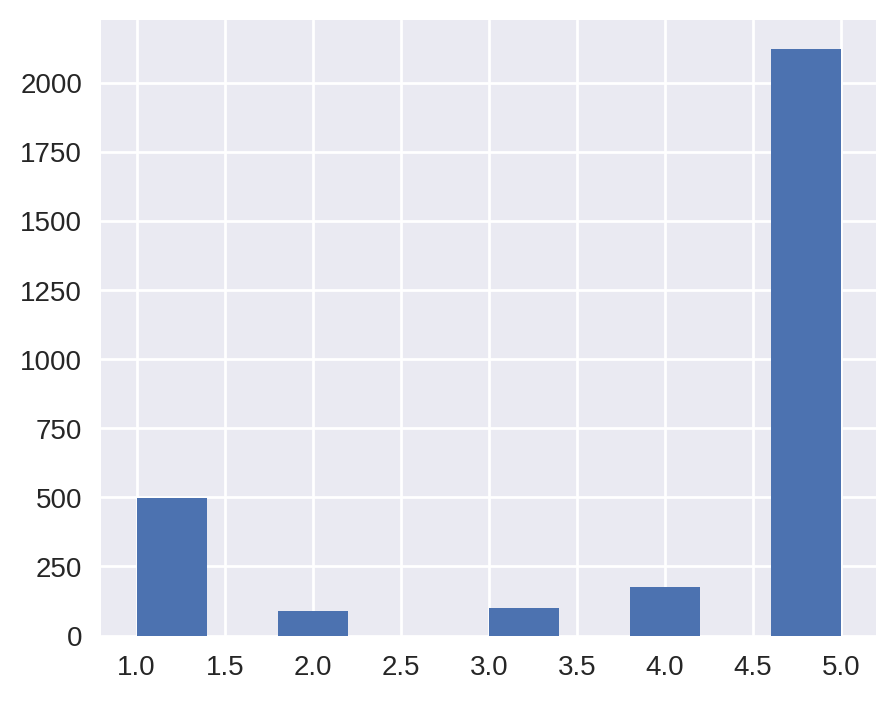

In [47]:
# Menampilkan review score ke dalam bar chart
plt.figure(figsize=[5,4])
plt.hist(df_alodokter['score'])
plt.show()

In [51]:
# Menambah kolom sentiment_rating
df_alodokter.loc[:, 'sentiment_rating'] = df_alodokter['score'].apply(lambda x: 'positive' if x > 3 else ('neutral' if x == 3 else 'negative'))

In [52]:
df_alodokter.loc[:,["content", "score", "sentiment_label", "sentiment_score", "sentiment_rating"]]

,content,score,sentiment_label,sentiment_score,sentiment_rating
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,0.339295,positive
1,baik' untuk kesehatan,5,neutral,0.344955,positive
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,neutral,0.341136,positive
3,sangat baik dan memuaskan,5,positive,0.356649,positive
4,sangat baik,5,negative,0.373096,positive
...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,neutral,0.343232,negative
2996,sangat membantu ketika butuh jawaban segera,5,positive,0.344162,positive
2997,good app with good price,5,negative,0.340262,positive
2998,alhamdulillah resep obat yg diberikan dokter b...,5,neutral,0.340490,positive


In [53]:
# Mengubah label ke dalam bentuk numerik
sentiment_mapping = {
    "positive": 0,
    "neutral": 1,
    "negative": 2
}

In [54]:
df_alodokter['sentiment_numeric'] = df_alodokter['sentiment_label'].map(sentiment_mapping)
df_alodokter['rating_numeric'] = df_alodokter['sentiment_rating'].map(sentiment_mapping)

<ipython-input-54-42129b6735e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter['sentiment_numeric'] = df_alodokter['sentiment_label'].map(sentiment_mapping)
<ipython-input-54-42129b6735e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter['rating_numeric'] = df_alodokter['sentiment_rating'].map(sentiment_mapping)


In [56]:
# Buat tabel kontingensi
contingency_table = pd.crosstab(df_alodokter['sentiment_numeric'], df_alodokter['rating_numeric'],
                                 rownames=['Sentiment Label'], colnames=['Sentiment Rating'])

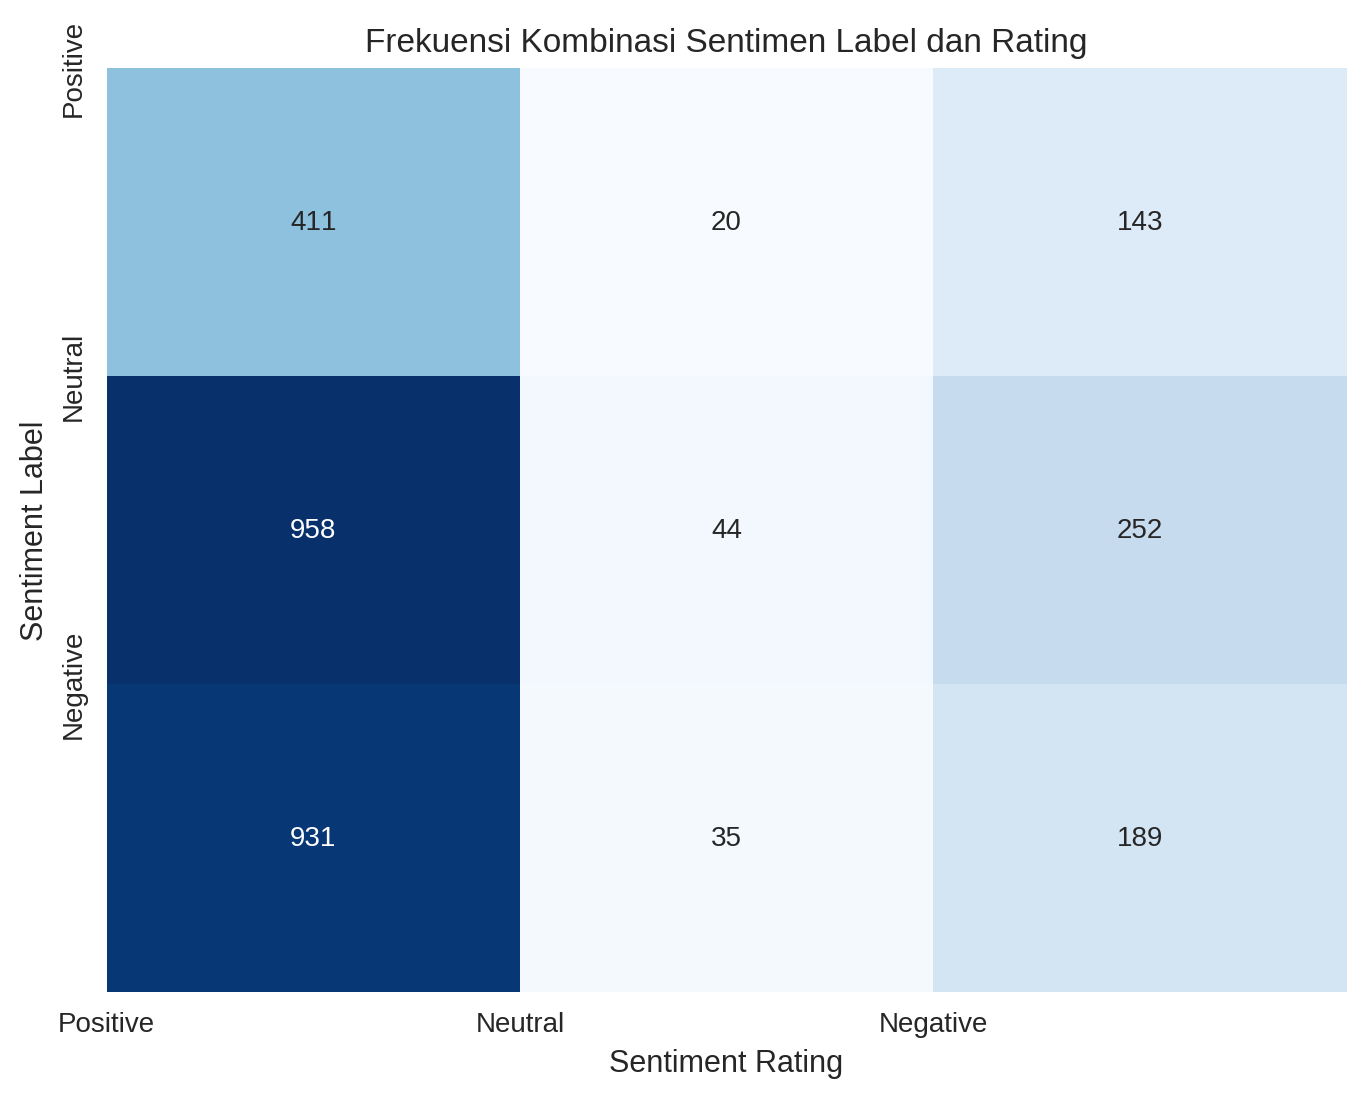

In [57]:
# Buat heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Frekuensi Kombinasi Sentimen Label dan Rating')
plt.xlabel('Sentiment Rating')
plt.ylabel('Sentiment Label')
plt.xticks(ticks=[0, 1, 2], labels=['Positive', 'Neutral', 'Negative'])
plt.yticks(ticks=[0, 1, 2], labels=['Positive', 'Neutral', 'Negative'])
plt.show()

**Kesimpulan visualisasi heatmap** di atas, yaitu:


*   Nilai yang bernilai positive-positive antara sentiment label dengan sentiment rating adalah 411, sedangkan neutral-neutral adalah 44, dan negative-negative adalah 189.
* Berdasarkan jumlah kecocokan antara sentiment label dengan sentiment rating, dapat dikatakan bahwa model zero shot learning tidak dapat memprediksi secara tepat terkait label pada 3k data review aplikasi AloDokter berbahasa Indonesia. Namun, jika melihat review secara menyeluruh, sentiment rating juga tidak dapat dijadikan sebagai acuan dalam menilai polaritas suatu review karena terdapat kasus dimana pengguna memberikan ulasan negative, tetapi memberi rating 5, dan kemungkinan serupa lainnya.



In [58]:
# Hitung jumlah kategori di sentiment_label
label_counts = df_alodokter['sentiment_label'].value_counts()
rating_counts = df_alodokter['sentiment_rating'].value_counts()

In [59]:
# Gabungkan hasilnya ke dalam DataFrame
comparison_df = pd.DataFrame({
    'Label': label_counts.index,
    'Sentiment_Label_Count': label_counts.values,
    'Sentiment_Rating_Count': rating_counts.reindex(label_counts.index, fill_value=0).values
})

# Tambahkan kolom selisih
comparison_df['Difference'] = comparison_df['Sentiment_Label_Count'] - comparison_df['Sentiment_Rating_Count']

# Tampilkan hasil
print(comparison_df)

      Label  Sentiment_Label_Count  Sentiment_Rating_Count  Difference
0   neutral                   1254                      99        1155
1  negative                   1155                     584         571
2  positive                    574                    2300       -1726


Dari perhitungan di atas juga dapat dilihat bahwa jumlah positive, neutral, dan negative dari sentiment label dan rating memiliki perbedaan yang cukup jauh.

# Text Analysis (Sebelum Stopwords)

In [60]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Untuk fungsi word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [61]:
# Menghitung jumlah kata dengan tokenisasi menggunakan NLTK
df_alodokter['wordCount'] = df_alodokter['content'].apply(lambda x: len(word_tokenize(x)))
df_alodokter['uppercaseCharCount'] = [sum(char.isupper() for char in review) for review in df_alodokter['content']]
df_alodokter['specialCharCount'] = [sum(char in string.punctuation for char in review) for review in df_alodokter['content']]

<ipython-input-61-6a1cd59cffbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter['wordCount'] = df_alodokter['content'].apply(lambda x: len(word_tokenize(x)))
<ipython-input-61-6a1cd59cffbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alodokter['uppercaseCharCount'] = [sum(char.isupper() for char in review) for review in df_alodokter['content']]
<ipython-input-61-6a1cd59cffbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [62]:
df_alodokter.loc[:,["content","score","sentiment_label","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_label,wordCount,uppercaseCharCount,specialCharCount
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,7,0,0
1,baik' untuk kesehatan,5,neutral,4,0,1
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,neutral,11,0,2
3,sangat baik dan memuaskan,5,positive,4,0,0
4,sangat baik,5,negative,2,0,0
...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,neutral,29,0,4
2996,sangat membantu ketika butuh jawaban segera,5,positive,6,0,0
2997,good app with good price,5,negative,5,0,0
2998,alhamdulillah resep obat yg diberikan dokter b...,5,neutral,46,0,3


In [63]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

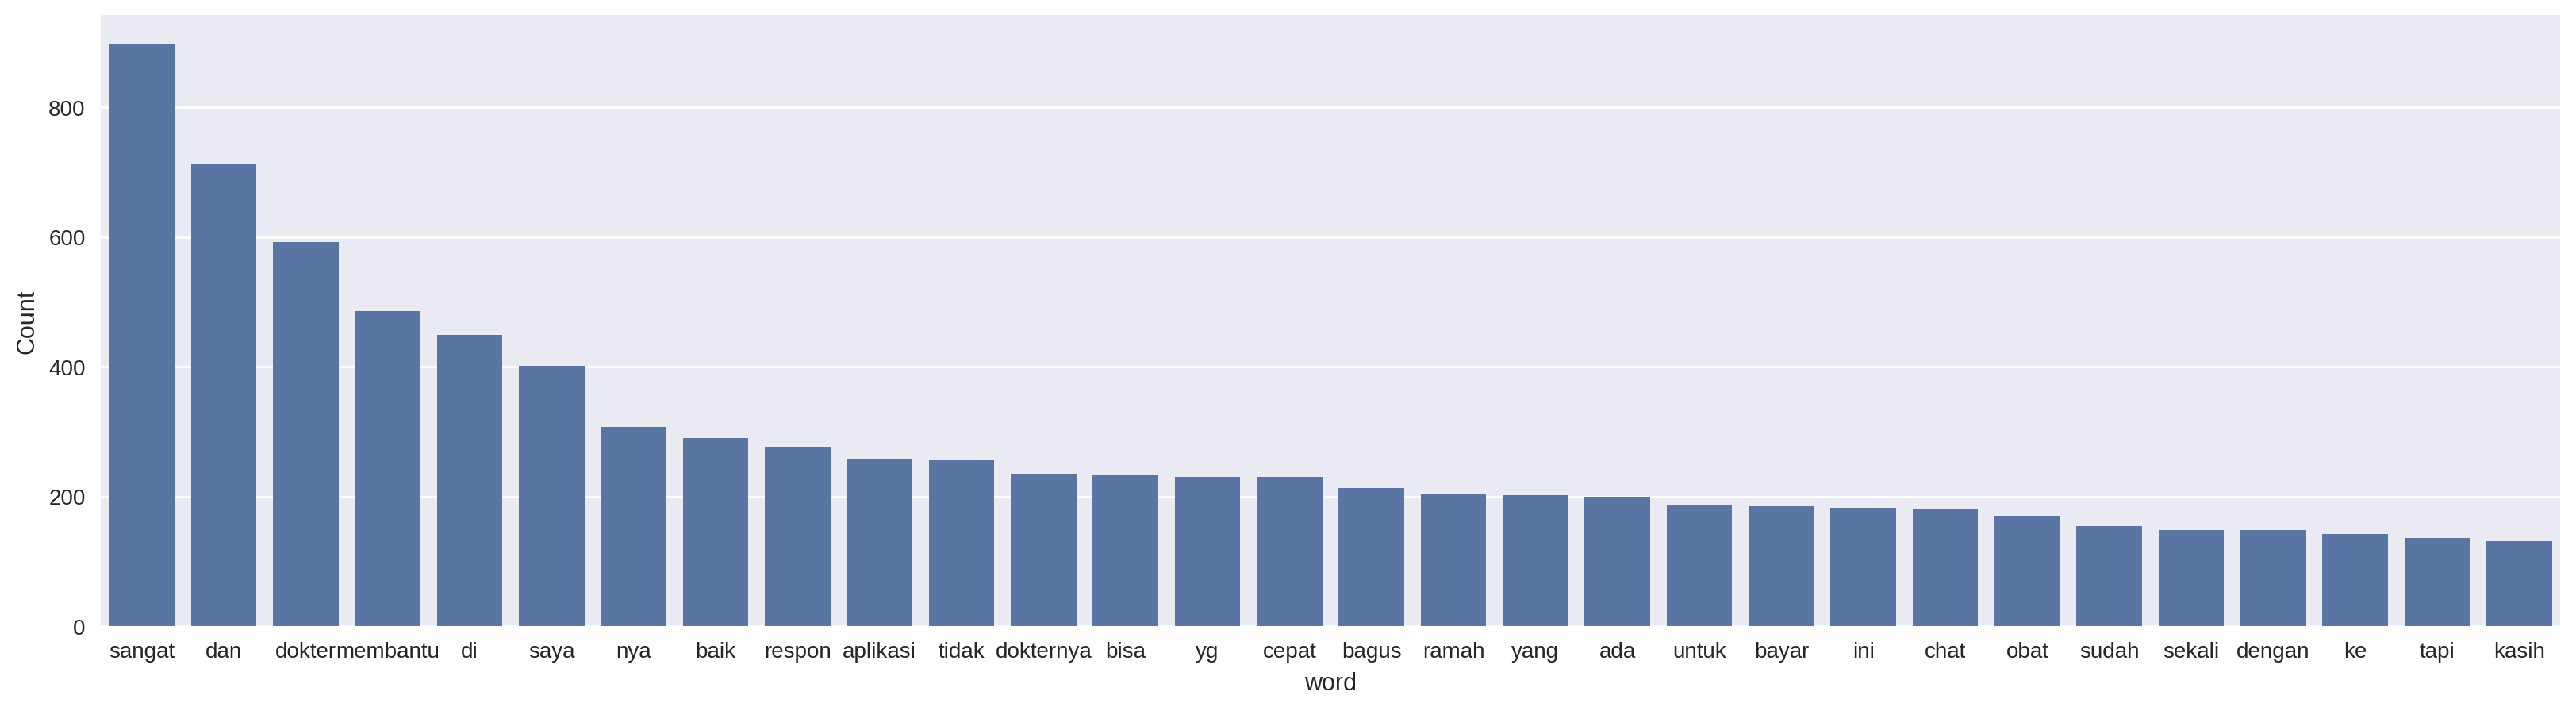

In [64]:
freq_words(df_alodokter['content'])

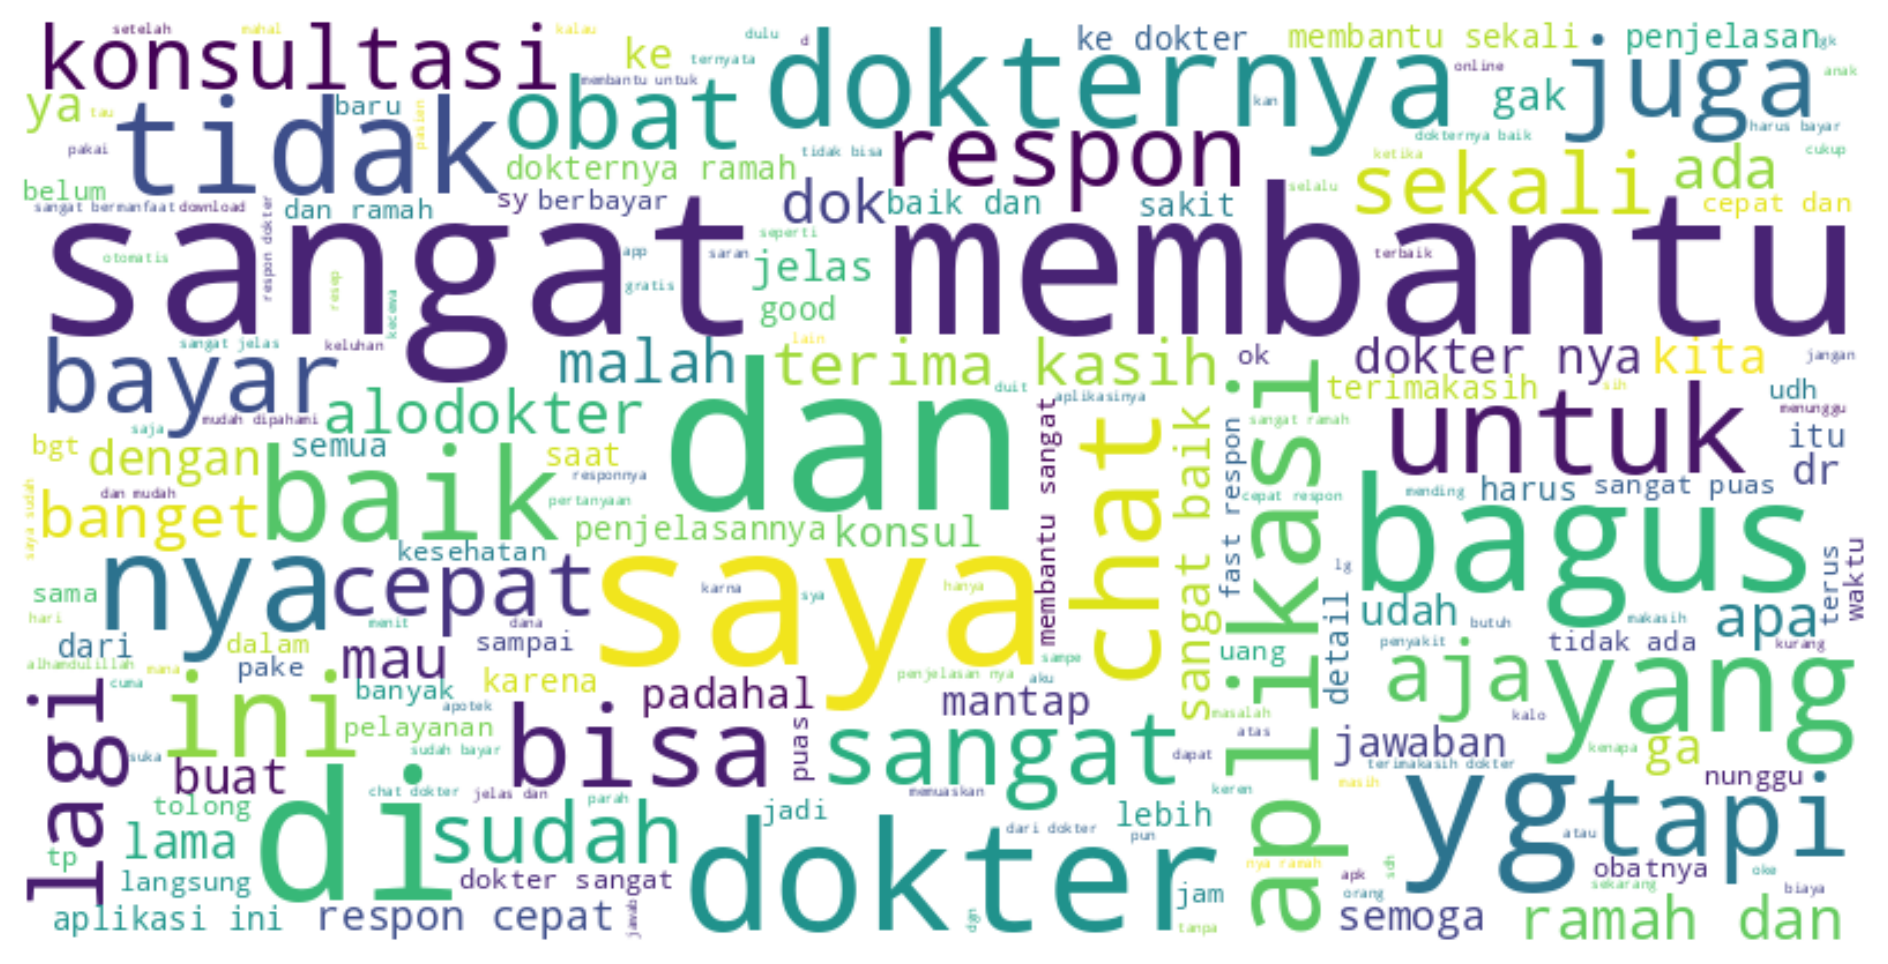

In [65]:
# Gabungkan semua kata dari kolom 'content' menjadi satu string
all_words_before = ' '.join(df_alodokter['content'])

# WordCloud sebelum menghapus stopwords
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(all_words_before)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.show()

In [66]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_before_stopwords.csv'
df_alodokter.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_before_stopwords.csv


## Menghapus tanda baca

In [67]:
# Membuat dataframe baru
df_alodokter_stopwords = df_alodokter.loc[:,["content", "score", "sentiment_label", "sentiment_rating", "wordCount"]]
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['content'].apply(
    lambda x: x.translate(str.maketrans("","",string.punctuation)))
df_alodokter_stopwords

,content,score,sentiment_label,sentiment_rating,wordCount,review_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,positive,7,informasi dan rekomendasi lengkap dan mudah di...
1,baik' untuk kesehatan,5,neutral,positive,4,baik untuk kesehatan
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,neutral,positive,11,terimakasih dok sehat sehat ya terimakasih ata...
3,sangat baik dan memuaskan,5,positive,positive,4,sangat baik dan memuaskan
4,sangat baik,5,negative,positive,2,sangat baik
...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,neutral,negative,29,udah bayar mahal dokter online tp tidak meresp...
2996,sangat membantu ketika butuh jawaban segera,5,positive,positive,6,sangat membantu ketika butuh jawaban segera
2997,good app with good price,5,negative,positive,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,neutral,positive,46,alhamdulillah resep obat yg diberikan dokter b...


# Menghapus Stopwords

In [68]:
import requests

# Unduh daftar stopwords dari URL
url = 'https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt'
response = requests.get(url)

# Simpan daftar stopwords ke file lokal
with open('id_stopwords.txt', 'w') as file:
    file.write(response.text)

# Baca stopwords dari file
with open('id_stopwords.txt', 'r') as file:
    stopwords_id = file.read().splitlines()

# Menampilkan beberapa stopwords
print(f"Terdapat total {len(stopwords_id)} kata stopwords dalam bahasa Indonesia:")
print(stopwords_id[:10])  # Menampilkan 10 kata pertama dari daftar stopwords


Terdapat total 758 kata stopwords dalam bahasa Indonesia:
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir']


In [69]:
# Fungsi untuk menghapus stopwords dari teks
def remove_stopwords(text, stopwords_list):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(filtered_words)

In [70]:
# Menghapus stopwords dari kolom 'review_without_stopwords'
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

# Menampilkan hasil
df_alodokter_stopwords

,content,score,sentiment_label,sentiment_rating,wordCount,review_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,positive,7,informasi rekomendasi lengkap mudah dipahami
1,baik' untuk kesehatan,5,neutral,positive,4,kesehatan
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,neutral,positive,11,terimakasih dok sehat sehat ya terimakasih sar...
3,sangat baik dan memuaskan,5,positive,positive,4,memuaskan
4,sangat baik,5,negative,positive,2,
...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,neutral,negative,29,udah bayar mahal dokter online tp merespon 30 ...
2996,sangat membantu ketika butuh jawaban segera,5,positive,positive,6,membantu butuh
2997,good app with good price,5,negative,positive,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,neutral,positive,46,alhamdulillah resep obat yg dokter keluarga re...


In [71]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # Memilih kata yang paling sering muncul
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel='Count')
    plt.show()

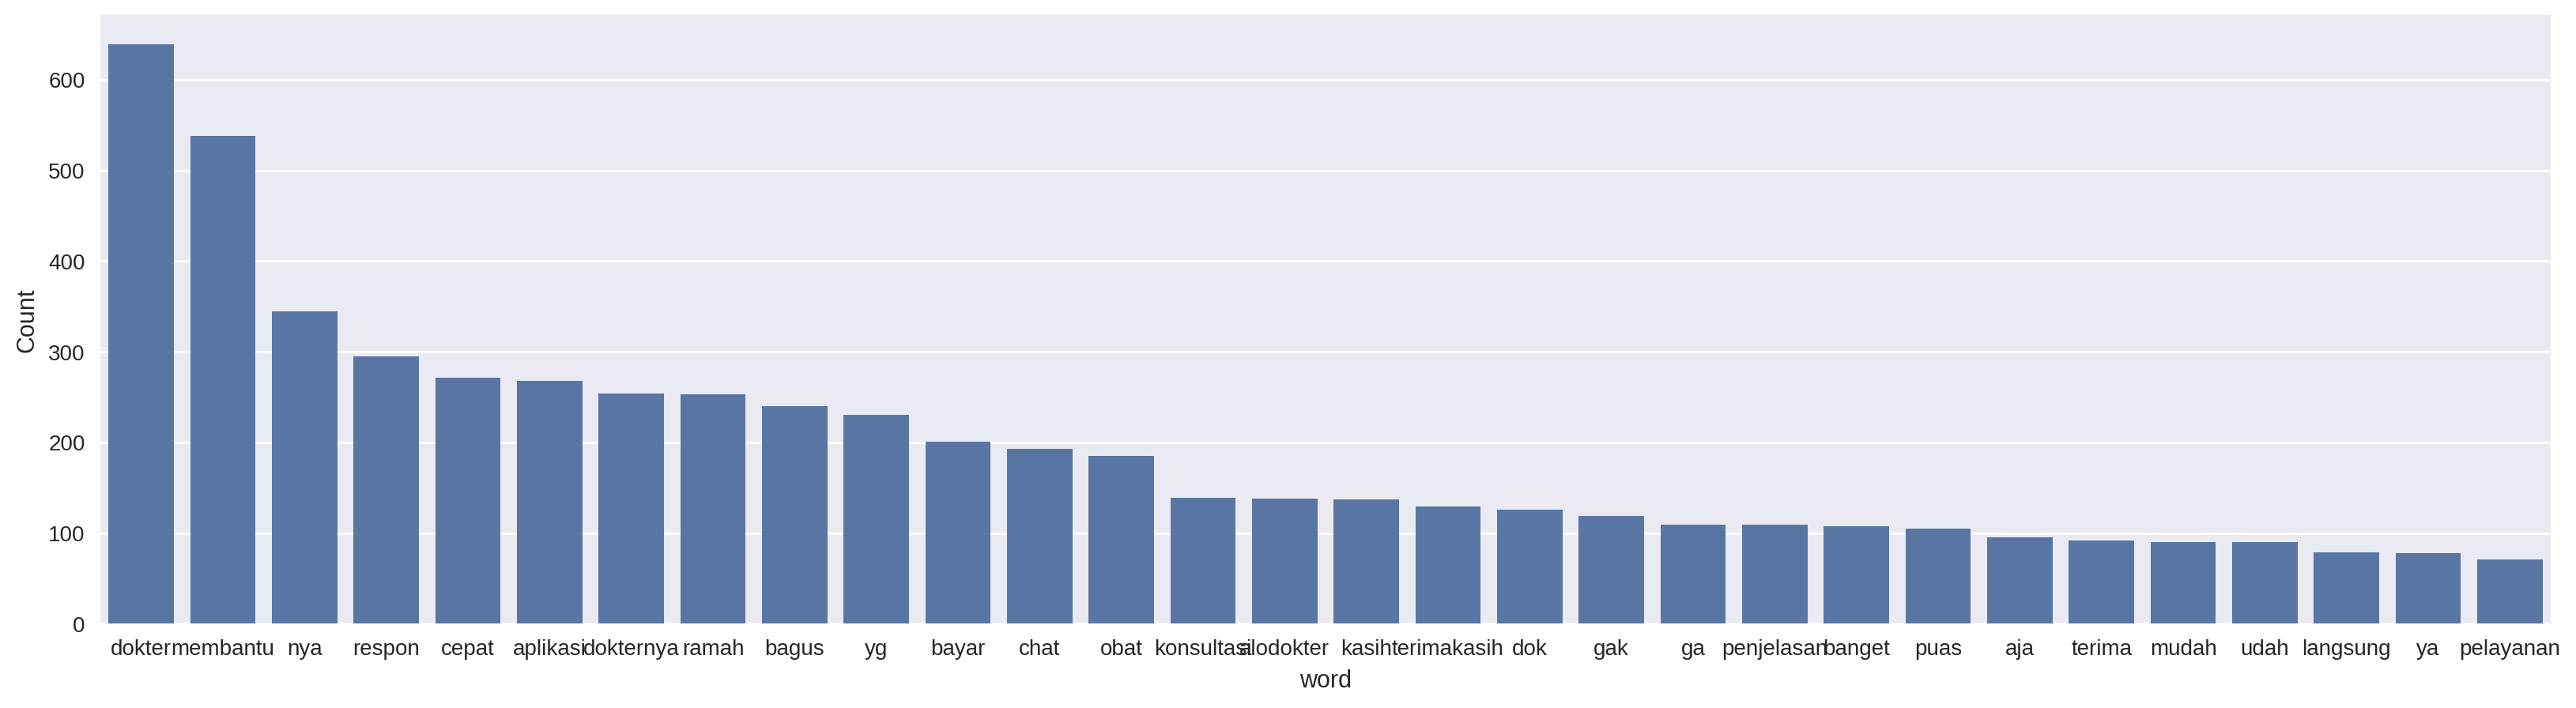

In [72]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

In [73]:
stopwords_id = stopwords_id + ["nya", "yg", "dok", "gak", "ga", "banget", "aja", "udah", "ya"]

In [74]:
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

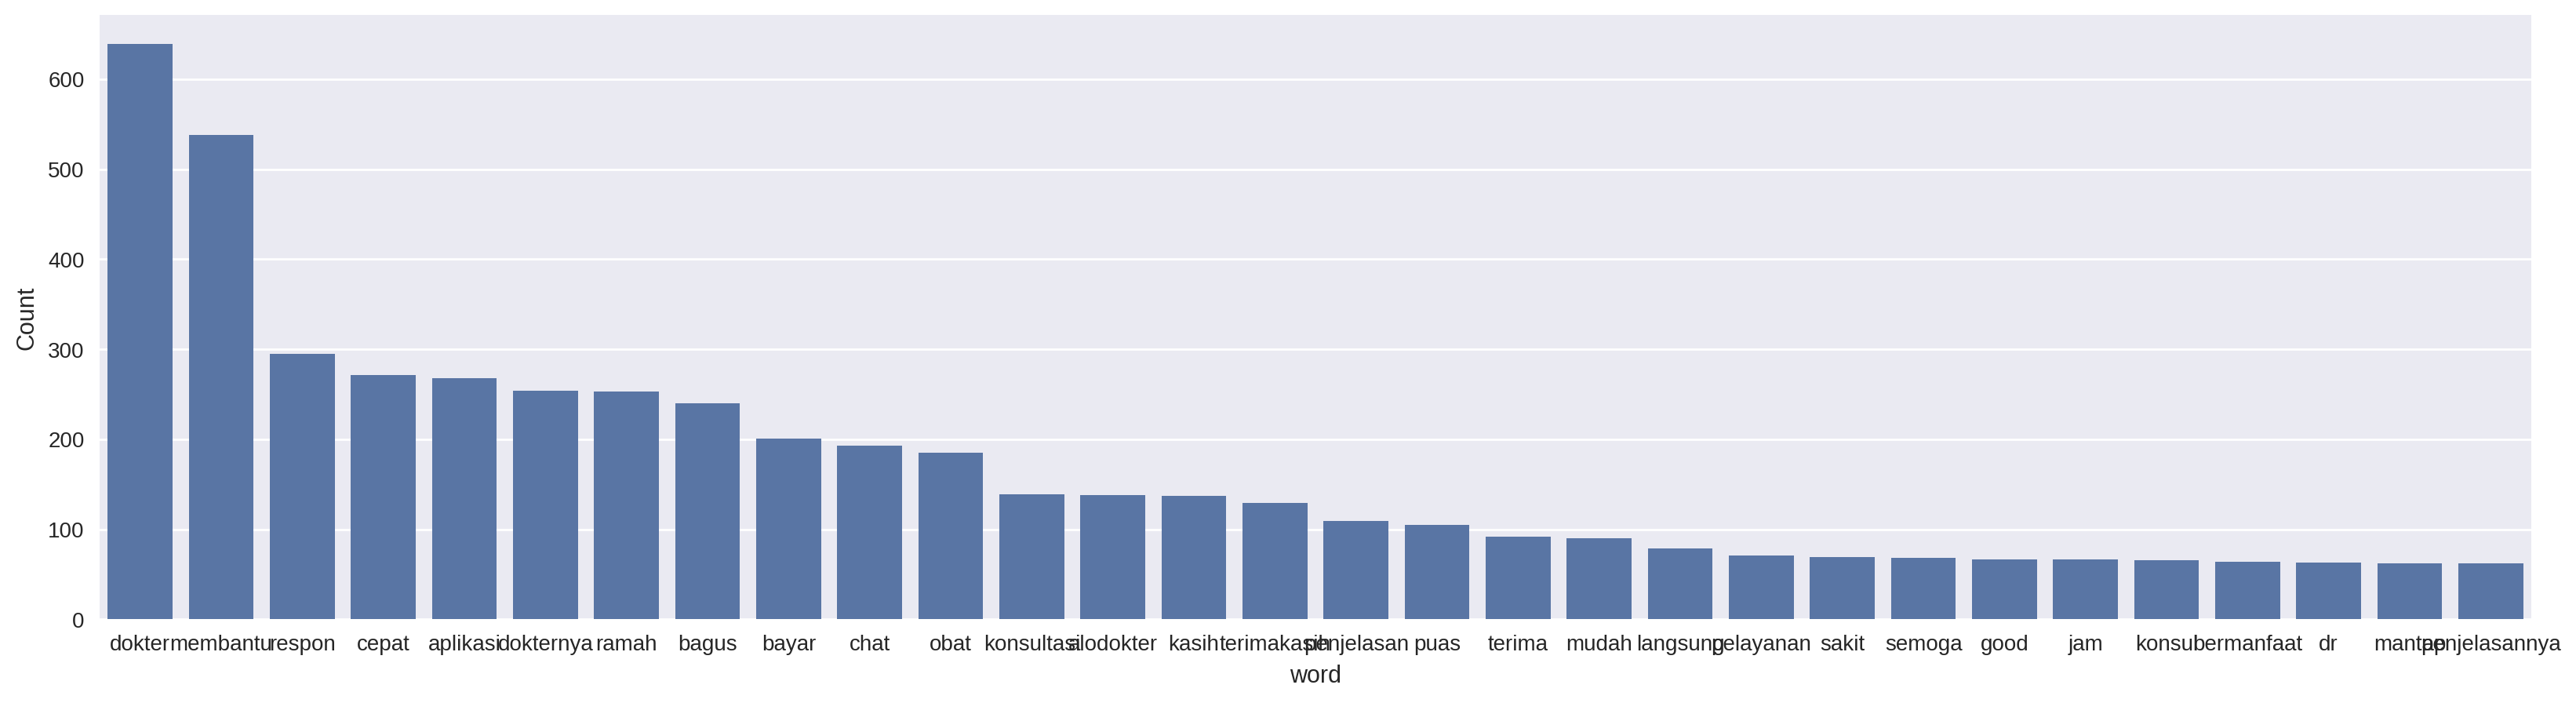

In [75]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

In [76]:
stopwords_id = stopwords_id + ["dr"]
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

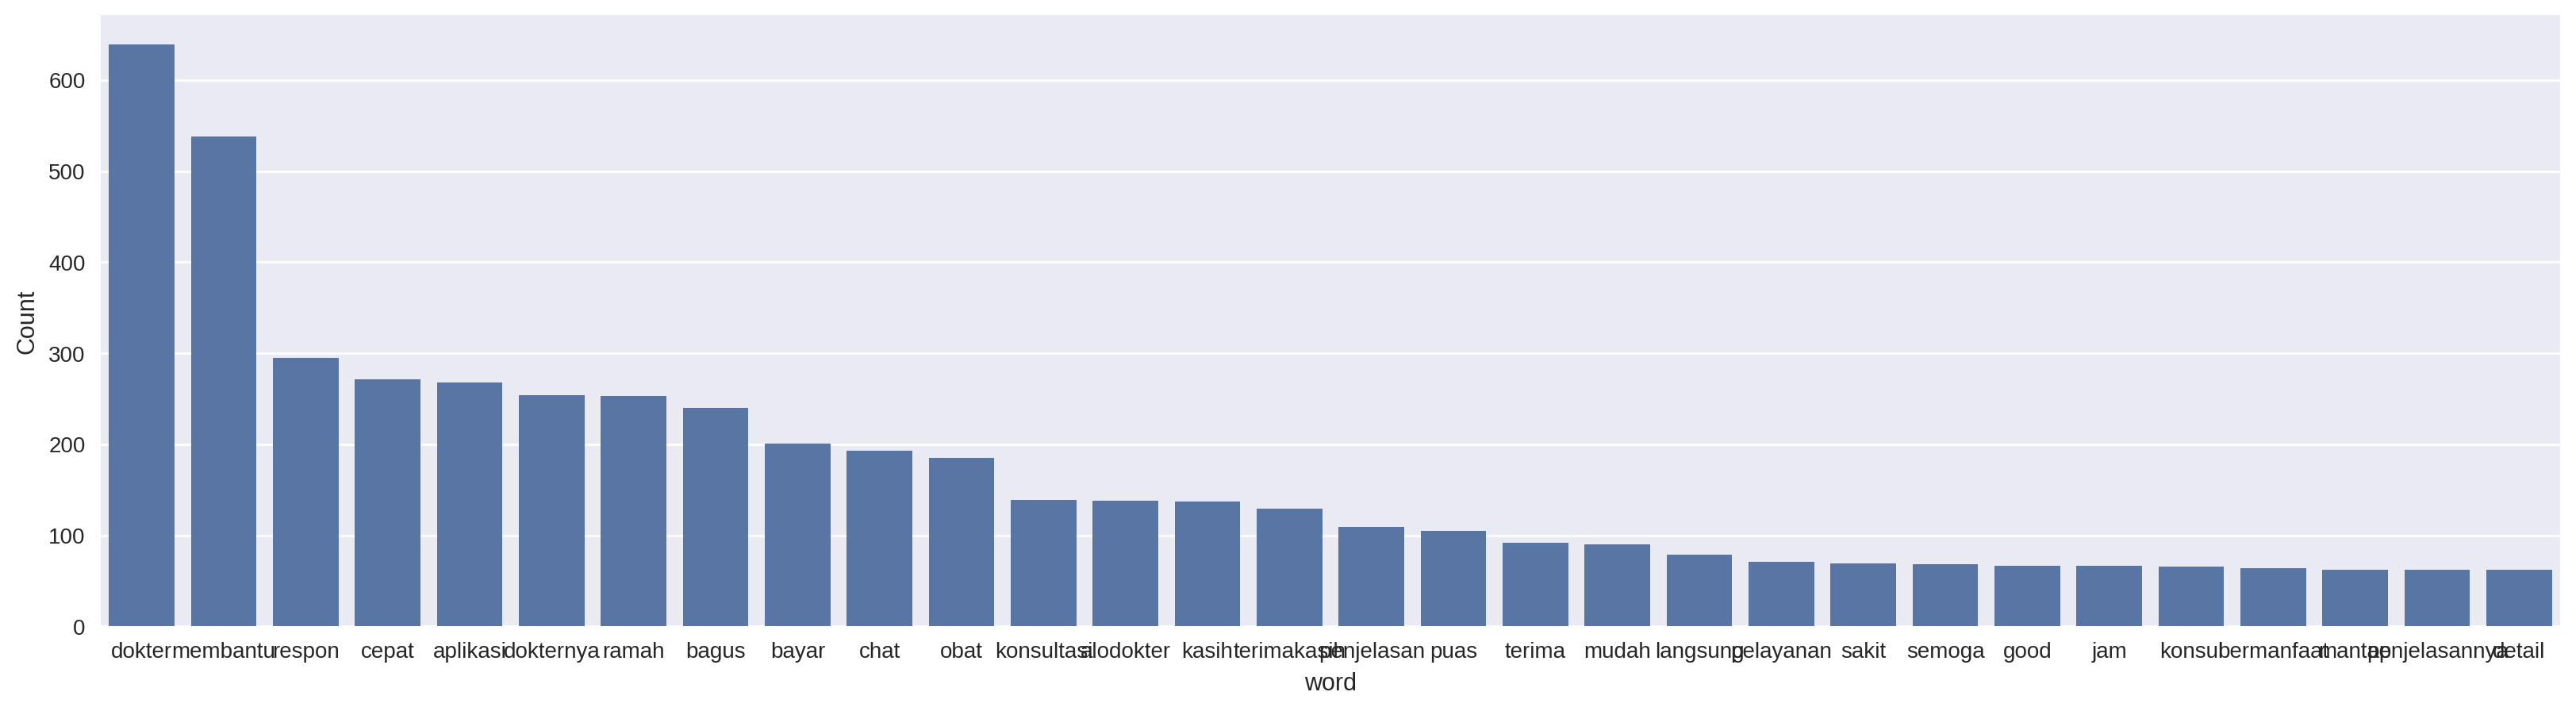

In [77]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

# Text Analysis (Setelah Stopwords)

In [78]:
# Menghitung jumlah kata setelah menghapus stopwords
df_alodokter_stopwords['wordCount_after_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: len(x.split())
)

In [79]:
df_alodokter_stopwords.loc[:,["content","score","sentiment_label", "sentiment_rating","wordCount","review_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_label,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,positive,7,informasi rekomendasi lengkap mudah dipahami,5
1,baik' untuk kesehatan,5,neutral,positive,4,kesehatan,1
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,neutral,positive,11,terimakasih sehat sehat terimakasih saran sara...,6
3,sangat baik dan memuaskan,5,positive,positive,4,memuaskan,1
4,sangat baik,5,negative,positive,2,,0
...,...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,neutral,negative,29,bayar mahal dokter online tp merespon 30 menit...,18
2996,sangat membantu ketika butuh jawaban segera,5,positive,positive,6,membantu butuh,2
2997,good app with good price,5,negative,positive,5,good app with good price,5
2998,alhamdulillah resep obat yg diberikan dokter b...,5,neutral,positive,46,alhamdulillah resep obat dokter keluarga repot...,20


In [80]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_after_stopwords.csv'
df_alodokter_stopwords.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_after_stopwords.csv


# Stemming

Stemming berguna untuk memotong akhir kata/imbuhan, sehingga kata kembali menjadi bentuk dasarnya.

In [81]:
# Mengunduh library untuk stemming Bahasa Indonesia
!pip install PySastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.6 MB/s eta 0:00:00


In [82]:
# Import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [83]:
# Fungsi untuk stemming
def stemming_indonesia(text):
    if text is not None:
        # Lakukan stemming dan kembalikan hasilnya
        return stemmer.stem(text)
    return ''

In [84]:
# Terapkan stemming pada kolom 'review_without_stopwords'
df_alodokter_stopwords['review_stem_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(lambda x: stemming_indonesia(x))
# Menampilkan hasil untuk beberapa baris
df_alodokter_stopwords.loc[0:3, ['review_without_stopwords', 'review_stem_without_stopwords']]

,review_without_stopwords,review_stem_without_stopwords
0,informasi rekomendasi lengkap mudah dipahami,informasi rekomendasi lengkap mudah paham
1,kesehatan,sehat
2,terimakasih sehat sehat terimakasih saran sara...,terimakasih sehat sehat terimakasih saran saran
3,memuaskan,muas


In [87]:
df_alodokter_stopwords = df_alodokter_stopwords[df_alodokter_stopwords['review_without_stopwords'] != '']

In [88]:
df_alodokter_stopwords[df_alodokter_stopwords['review_without_stopwords'] == '']

,content,score,sentiment_label,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords


In [85]:
# Menghapus semua baris yang memiliki nilai None di seluruh DataFrame
df_alodokter_stopwords = df_alodokter_stopwords.dropna()

In [89]:
df_alodokter_stopwords

,content,score,sentiment_label,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,positive,7,informasi rekomendasi lengkap mudah dipahami,5,informasi rekomendasi lengkap mudah paham
1,baik' untuk kesehatan,5,neutral,positive,4,kesehatan,1,sehat
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,neutral,positive,11,terimakasih sehat sehat terimakasih saran sara...,6,terimakasih sehat sehat terimakasih saran saran
3,sangat baik dan memuaskan,5,positive,positive,4,memuaskan,1,muas
5,respon cepat... pelayanan baik sekali,5,negative,positive,6,respon cepat pelayanan,3,respon cepat layan
...,...,...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,neutral,negative,29,bayar mahal dokter online tp merespon 30 menit...,18,bayar mahal dokter online tp merespon 30 menit...
2996,sangat membantu ketika butuh jawaban segera,5,positive,positive,6,membantu butuh,2,bantu butuh
2997,good app with good price,5,negative,positive,5,good app with good price,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,neutral,positive,46,alhamdulillah resep obat dokter keluarga repot...,20,alhamdulillah resep obat dokter keluarga repot...


In [90]:
# Hasil akhir
df_alodokter_stopwords.loc[:,["content","score","sentiment_rating", "sentiment_label", "wordCount","review_without_stopwords", "wordCount_after_stopwords", 'review_stem_without_stopwords']]

,content,score,sentiment_rating,sentiment_label,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,positive,positive,7,informasi rekomendasi lengkap mudah dipahami,5,informasi rekomendasi lengkap mudah paham
1,baik' untuk kesehatan,5,positive,neutral,4,kesehatan,1,sehat
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,positive,neutral,11,terimakasih sehat sehat terimakasih saran sara...,6,terimakasih sehat sehat terimakasih saran saran
3,sangat baik dan memuaskan,5,positive,positive,4,memuaskan,1,muas
5,respon cepat... pelayanan baik sekali,5,positive,negative,6,respon cepat pelayanan,3,respon cepat layan
...,...,...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,negative,neutral,29,bayar mahal dokter online tp merespon 30 menit...,18,bayar mahal dokter online tp merespon 30 menit...
2996,sangat membantu ketika butuh jawaban segera,5,positive,positive,6,membantu butuh,2,bantu butuh
2997,good app with good price,5,positive,negative,5,good app with good price,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,positive,neutral,46,alhamdulillah resep obat dokter keluarga repot...,20,alhamdulillah resep obat dokter keluarga repot...


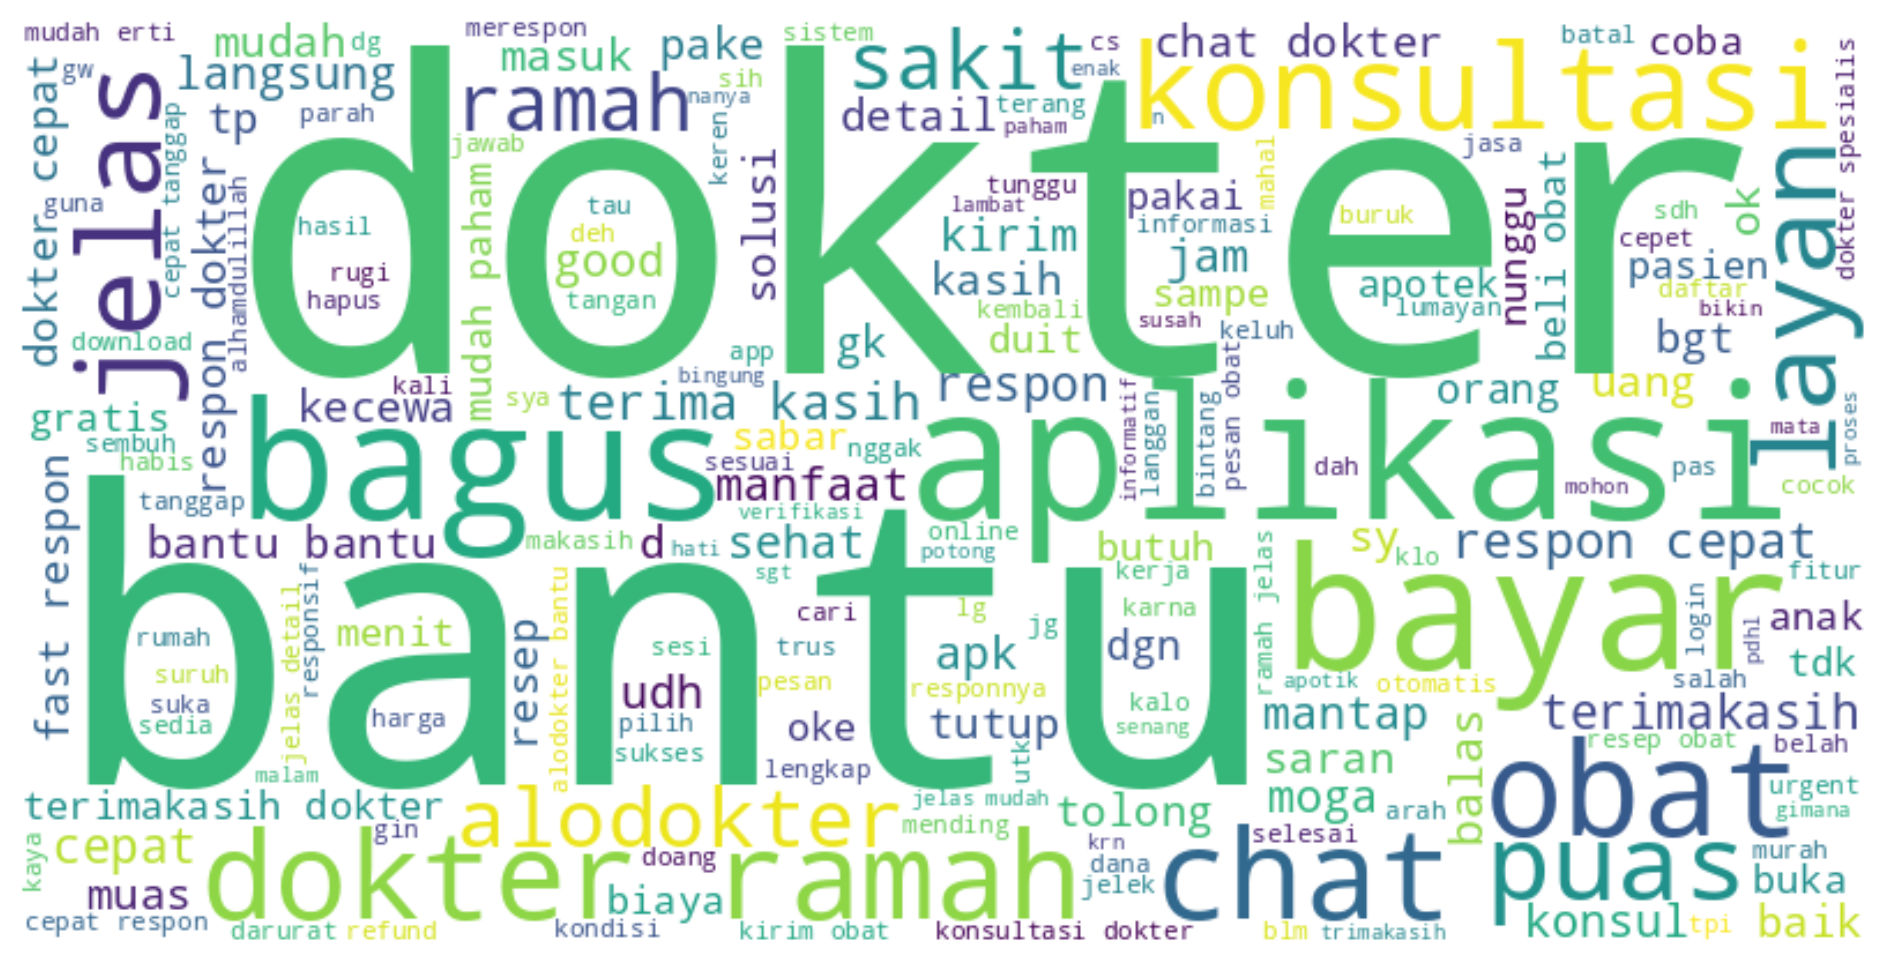

In [94]:
# Gabungkan semua kata dari kolom 'review_stem_without_stopwords' menjadi satu string
text = ' '.join(df_alodokter_stopwords['review_stem_without_stopwords'])

# WordCloud setelah menghapus stopwords dan stemming
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [91]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_after_stopwords_stemming.csv'
df_alodokter_stopwords.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_after_stopwords_stemming.csv
